# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

### Project Overview:
Sparkify is digial music streaming provider similar to other popular music streaming providers like Spotify or Pandora.
User can use Sparkify to play their favourite music either using free tier ( which has advertisemetns playing between songs ) or a paid subscription model. 

While users use Sparify to play their favourite music, different interactions which a user makes with Sparkify are captured as various events. 
Out of total users of Sparkify, some users do cancel their subscription ( called as Churn in this context) with Sparkify which means a possible business loss for Sparkify. And hence if there is a way to identify if a particular user is going to churn then an appropriate action can be initiated by Sparkify team to possibly avoid this churn and also avoiding potential business loss for Sparkify.

In this project, we would try to evaluate if there is a way to make a prediction (using machine learning) about if a user may churn in future by analysing past interactions of users with Sparkify.     

#### Problem statement
Predicting if a user will churn or not for a digital music streaming company Sparkify by analysing interactions which a user would have had with Sparkify app

#### Metrics: 
Considering it is a classification problem, metrics like accuracy , recall, precision and f1-score can be considered to evaluate model performance. Exact choice of metric to chose will be done post completing EDA for for features as well as output labels.

In [1]:
# import libraries
import pyspark
from pyspark.sql import SparkSession

import datetime


import pyspark.sql.functions as sf
import pyspark.sql.types as st

from pyspark.sql.functions import isnan

from pyspark.ml.feature import VectorAssembler

from pyspark.sql import Window
from pyspark.sql.functions import desc
from pyspark.sql.functions import sum as Fsum
import pyspark.sql.functions as F

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import pandas as pd
from time import time
import re
import numpy as np
import scipy
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import random
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify_Capstone_Project").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#loading mini-dataset file
d_path = './mini_sparkify_event_data.json'
sprkfy_evnt_mn_data = spark.read.json(d_path)

In [4]:
#checking few entries from dataset
sprkfy_evnt_mn_data.show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   

In [5]:
#checking schema for datasets
sprkfy_evnt_mn_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
#checking total entries available in dataset
print('total entries available in dataset',sprkfy_evnt_mn_data.count())

total entries available in dataset 286500


In [7]:
# Getting count of unique values in each of columns available in dataset
data_clmns = sprkfy_evnt_mn_data.columns
for i in data_clmns:
    print('Total Unique Entries for',i,sprkfy_evnt_mn_data.select(i).dropDuplicates().count())

Total Unique Entries for artist 17656
Total Unique Entries for auth 4
Total Unique Entries for firstName 190
Total Unique Entries for gender 3
Total Unique Entries for itemInSession 1322
Total Unique Entries for lastName 174
Total Unique Entries for length 14866
Total Unique Entries for level 2
Total Unique Entries for location 115
Total Unique Entries for method 2
Total Unique Entries for page 22
Total Unique Entries for registration 226
Total Unique Entries for sessionId 2354
Total Unique Entries for song 58481
Total Unique Entries for status 3
Total Unique Entries for ts 277447
Total Unique Entries for userAgent 57
Total Unique Entries for userId 226


In [8]:
# Check the number of missing values in userId and sessionId
print("Checking Number of missing values:")
for coln in ['userId', 'sessionId']:
    missing_count = sprkfy_evnt_mn_data.filter((isnan(sprkfy_evnt_mn_data[coln])) | \
                                               (sprkfy_evnt_mn_data[coln].isNull()) | \
                                               (sprkfy_evnt_mn_data[coln] == "")).count()
    print(f"number of missing values in {coln}", missing_count)

Checking Number of missing values:
number of missing values in userId 8346
number of missing values in sessionId 0


We do see missing values for some userIDs. 
since we are trying to predict which userIds are going to churn, we cannot just replace missing values by 0.
Instead, we need to understand about how & where do such missing values exist for UserIds.
and basis that decide further course of action

In [9]:
#Checking type of pages where userId is null
sprkfy_evnt_mn_data.select('page').where((sprkfy_evnt_mn_data.userId == '') | \
                                        (sprkfy_evnt_mn_data[coln].isNull()) | \
                                        (sprkfy_evnt_mn_data[coln] == ""))\
                                        .dropDuplicates().show(20)

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



It seems that userIds with empty string either prior to sign-in or registration or in process of completing registration. Therefore, the rows corresponding to empty userIds can be dropped.

In [10]:
# Dropping entries which has userId as null
sprkfy_evnt_mn_data = sprkfy_evnt_mn_data.filter(sprkfy_evnt_mn_data['userId'] != "")

In [11]:
# Re-Check the number of missing values in userId
print("Checking Number of missing values:")
for coln in ['userId', 'sessionId']:
    missing_count = sprkfy_evnt_mn_data.filter((isnan(sprkfy_evnt_mn_data[coln])) | \
                                               (sprkfy_evnt_mn_data[coln].isNull()) | \
                                               (sprkfy_evnt_mn_data[coln] == "")).count()
    print(f"number of missing values in {coln}", missing_count)

Checking Number of missing values:
number of missing values in userId 0
number of missing values in sessionId 0


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [12]:
# Definining a column Churn
sprkfy_evnt_mn_data_lbld = sprkfy_evnt_mn_data.withColumn('churn',sprkfy_evnt_mn_data.auth == 'Cancelled')

sprkfy_evnt_mn_data_lbld  = sprkfy_evnt_mn_data_lbld.withColumn('churn1',sprkfy_evnt_mn_data_lbld.churn.cast('integer'))

sprkfy_evnt_mn_data_lbld = sprkfy_evnt_mn_data_lbld.drop('churn')

In [13]:
#Checking unique values & count of entries for Non-numerical columns of dataset
# this is done to understand values present each of Non-numerical columns along with distribution of each of values.
for i in ['auth','gender','level','location','method','page','song','status','userAgent']:
    (sprkfy_evnt_mn_data.groupBy(i).count().sort('count', ascending=False).show())

+---------+------+
|     auth| count|
+---------+------+
|Logged In|278102|
|Cancelled|    52|
+---------+------+

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+

+-----+------+
|level| count|
+-----+------+
| paid|222433|
| free| 55721|
+-----+------+

+--------------------+-----+
|            location|count|
+--------------------+-----+
|Los Angeles-Long ...|30131|
|New York-Newark-J...|23684|
|Boston-Cambridge-...|13873|
|Houston-The Woodl...| 9499|
|Charlotte-Concord...| 7780|
|Dallas-Fort Worth...| 7605|
|Louisville/Jeffer...| 6880|
|Philadelphia-Camd...| 5890|
|Chicago-Napervill...| 5114|
|    St. Louis, MO-IL| 4858|
|Phoenix-Mesa-Scot...| 4846|
|Vineland-Bridgeto...| 4825|
|          Wilson, NC| 4659|
|Denver-Aurora-Lak...| 4453|
|           Ionia, MI| 4428|
|San Antonio-New B...| 4373|
|        Danville, VA| 4257|
|Atlanta-Sandy Spr...| 4236|
|New Haven-Milford...| 4007|
|         Jackson, MS| 3839|
+--------------------+-----+
o

In [14]:
#Checking distribution of churned userIds within respective Non-numerical columns of dataset
for i in ['auth','gender','level','location','method','page','song','status','userAgent']:
    sprkfy_evnt_mn_data_lbld.groupBy(i).pivot('churn1').count().sort('1',ascending=False).show()
    
# with this, we conclude that there isn't any one particular event which is causing a user to churn.
# and hence it is essential that we analyze past behavioral trends of users before they churn.

+---------+------+----+
|     auth|     0|   1|
+---------+------+----+
|Cancelled|  null|  52|
|Logged In|278102|null|
+---------+------+----+

+------+------+---+
|gender|     0|  1|
+------+------+---+
|     M|123544| 32|
|     F|154558| 20|
+------+------+---+

+-----+------+---+
|level|     0|  1|
+-----+------+---+
| paid|222402| 31|
| free| 55700| 21|
+-----+------+---+

+--------------------+-----+---+
|            location|    0|  1|
+--------------------+-----+---+
|New York-Newark-J...|23679|  5|
|Los Angeles-Long ...|30128|  3|
|Miami-Fort Lauder...| 3762|  2|
|Spokane-Spokane V...| 3524|  2|
|         Jackson, MS| 3837|  2|
|Phoenix-Mesa-Scot...| 4844|  2|
|Philadelphia-Camd...| 5888|  2|
|           Flint, MI|  454|  2|
|Birmingham-Hoover...|   74|  1|
|  Corpus Christi, TX|   10|  1|
|   Memphis, TN-MS-AR|   61|  1|
|San Francisco-Oak...| 2646|  1|
|New Philadelphia-...| 1780|  1|
|Orlando-Kissimmee...| 1497|  1|
|Oxnard-Thousand O...|  915|  1|
|           Selma, AL| 20

Shortlisting varibles for further analysis

In [15]:
# #dropping following features : 
# firstName ( user id is present)
# lastName ( user id is present)
# location
# method ( each page type is classified as either PUT or GET)
# status ( each page type is classified as one of 3 values of status)

#dropping unwanted variables
sprkfy_evnt_mn_data_lbld_1 = sprkfy_evnt_mn_data_lbld.drop('firstName','lastName','location','method','status')

In [16]:
# Checking dataset entries after dropping few columns
sprkfy_evnt_mn_data_lbld_1.show(3)

+----------------+---------+------+-------------+---------+-----+--------+-------------+---------+-----------------+-------------+--------------------+------+------+
|          artist|     auth|gender|itemInSession|   length|level|    page| registration|sessionId|             song|           ts|           userAgent|userId|churn1|
+----------------+---------+------+-------------+---------+-----+--------+-------------+---------+-----------------+-------------+--------------------+------+------+
|  Martha Tilston|Logged In|     M|           50|277.89016| paid|NextSong|1538173362000|       29|        Rockpools|1538352117000|Mozilla/5.0 (Wind...|    30|     0|
|Five Iron Frenzy|Logged In|     M|           79|236.09424| free|NextSong|1538331630000|        8|           Canada|1538352180000|"Mozilla/5.0 (Win...|     9|     0|
|    Adam Lambert|Logged In|     M|           51| 282.8273| paid|NextSong|1538173362000|       29|Time For Miracles|1538352394000|Mozilla/5.0 (Wind...|    30|     0|
+---

In [17]:
# Creating a flag ("phase"),which will indicate if a particular event is of a churned or non-churned user
wndw = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
sprkfy_evnt_mn_data_lbld_2 = sprkfy_evnt_mn_data_lbld_1.withColumn("phase",Fsum("churn1").over(wndw)).sort("ts")


In [18]:
# checking split between churn Vs non-churn user events for each of values Within non-numric columns
# share of churn-user-events vs total would give insight into possibly imporant feature values while predicting churn
for i in ['auth','gender','level','page','song','userAgent']:
    temp = sprkfy_evnt_mn_data_lbld_2.groupBy(i).pivot("phase").count()
    temp.withColumn("share_of_churn",(F.col("1")/(F.col("0")+F.col("1"))*100).cast('integer')).sort("share_of_churn",ascending = False).show()


+---------+------+-----+--------------+
|     auth|     0|    1|share_of_churn|
+---------+------+-----+--------------+
|Logged In|233290|44812|            16|
|Cancelled|  null|   52|          null|
+---------+------+-----+--------------+

+------+------+-----+--------------+
|gender|     0|    1|share_of_churn|
+------+------+-----+--------------+
|     M| 97880|25696|            20|
|     F|135410|19168|            12|
+------+------+-----+--------------+

+-----+------+-----+--------------+
|level|     0|    1|share_of_churn|
+-----+------+-----+--------------+
| free| 43333|12388|            22|
| paid|189957|32476|            14|
+-----+------+-----+--------------+

+--------------------+------+-----+--------------+
|                page|     0|    1|share_of_churn|
+--------------------+------+-----+--------------+
|         Roll Advert|  2966|  967|            24|
|             Upgrade|   387|  112|            22|
|      Submit Upgrade|   127|   32|            20|
|         Thu

Analysing EDA so far we  get an insight that column "Page" and events associated with are among crucial feature while predicting Churn

In [19]:
# creating pivot table of page event to visualize trends
user_pg = sprkfy_evnt_mn_data_lbld_2.groupBy(['userId']).pivot('page').count().fillna(0)
df_user_pg = user_pg.toPandas()

df_user_pg = df_user_pg.rename(columns={"Cancellation Confirmation": "Churn"})
df_user_pg['Churn'] = df_user_pg['Churn'].replace({1: "Churn", 0: "No-Churn"})

In [20]:
# quick look at pivoted dataset
df_user_pg.head(3)

,userId,About,Add Friend,Add to Playlist,Cancel,Churn,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,3,4,8,0,No-Churn,5,0,2,20,5,387,7,0,3,0,1,6,21,2
1,100010,1,4,7,0,No-Churn,0,0,2,11,5,275,52,0,0,0,0,5,17,2
2,125,0,0,0,1,Churn,0,0,0,0,0,8,1,0,0,0,0,0,0,0


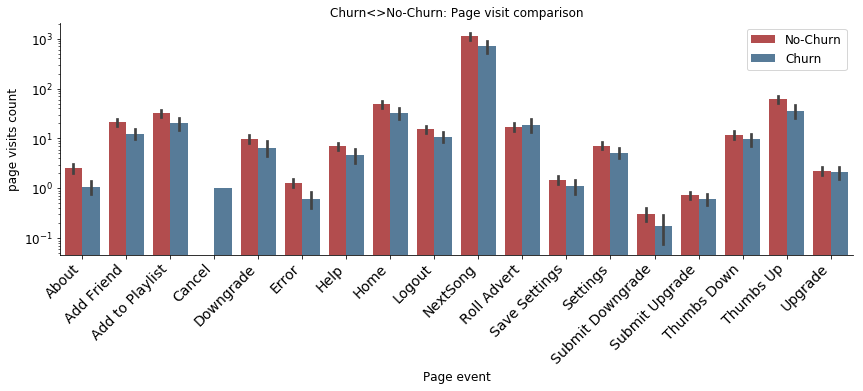

In [21]:
# Visualizing distribution of page events between Churn and No-churn users

page_events_pd = pd.melt(
    df_user_pg, id_vars=['userId', 'Churn'], 
    value_vars=list(df_user_pg.columns[1:].drop('Churn')),
    var_name='page', 
    value_name='number_visits'
).reset_index()

fig = plt.figure(figsize=(10, 6))
sns.factorplot(x="page", y="number_visits", hue="Churn", data=page_events_pd,
               kind="bar", aspect=3, legend=False, log=True,saturation=.5,palette="Set1");
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=12)
plt.xlabel("Page event", fontsize=12)
plt.ylabel("page visits count", fontsize=12)
plt.title("Churn<>No-Churn: Page visit comparison", fontsize=12)
plt.legend(loc='best', fontsize=12);

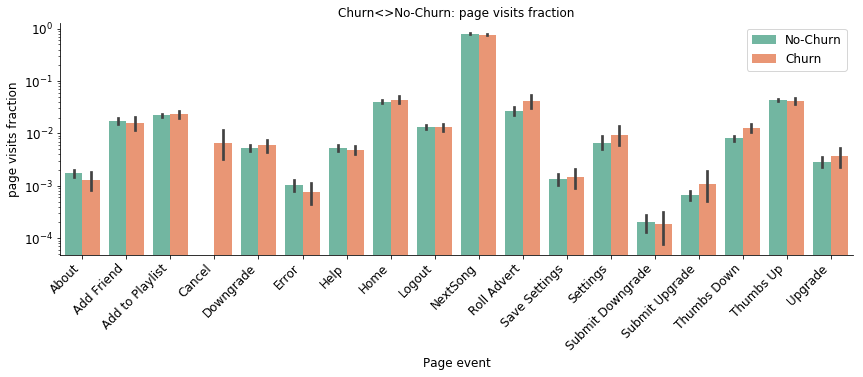

In [22]:
# Visualizing distribution of page_events_fraction between Churn and No-churn users

event_cols = [coln for coln in df_user_pg.columns[1:] if coln != 'Churn']
df_user_pg['total'] = df_user_pg[event_cols].sum(axis=1)
for coln in event_cols:
    df_user_pg[coln] = df_user_pg[coln] / df_user_pg['total']

page_events_frac_pd = pd.melt(
    df_user_pg, id_vars=['userId', 'Churn'], 
    value_vars=event_cols,
    var_name='page', 
    value_name='frac_visits'
).reset_index()

fig = plt.figure(figsize=(10, 6))
sns.factorplot(x="page", y="frac_visits", hue="Churn", data=page_events_frac_pd,
               kind="bar", aspect=3, legend=False, log=True,palette="Set2");
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Page event", fontsize=12)
plt.ylabel("page visits fraction", fontsize=12)
plt.title("Churn<>No-Churn: page visits fraction", fontsize=12)
plt.legend(loc='best', fontsize=12);

In [23]:
# Creating a local temporary view of working dataset
# This is done so as to create different feaures in next section
sprkfy_evnt_mn_data_lbld_2.createOrReplaceTempView("sprkfy_data_table1")

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [24]:
#creating list of users along with their "churn flag" ( phase )
usr_list = sprkfy_evnt_mn_data_lbld_2.select(['userId','phase']).dropDuplicates()

In [25]:
# quick look at count of userIds
usr_list.count()

225

Basis EDA performed between Churned and non-churned users, we are going to create following feaures for each of userIDs

1. avg_songs_per_session : how many songs a user plays on average in session 
2. avg_time_per_session : how much average time does a user spend on sparkify in each session


( Above 2 indicate engagement level of user )

3. days_since_regi : total days since user has been registered with sparkify
4. sess_cnt : total sessions which a user had with sparkify since registration
5. song_cnt : total songs which a user has played with sparkify since registration
6. art_cnt : total artists which a user has listened to with sparkify since registration 


(Above 4 features indicate key stats of user with sparkify since registration)

For following set of page events we create 2 features each for each of userIds ( total count of that page-event and total count of that page-event as a fraction of total-page-events )


7. Roll Advert
8. Thumbs Down
9. Thumbs Up
10. Settings 
11. NextSong 
12. Add Friend
13. About
14. Save Settings 
15. Add to Playlist
16. Help
17. Home
18. Submit Downgrade
19. Error


we also create a feature "pg_up_dwn_ratio" which compates total thumbs_up as a ratio of total thumbs_down

In [26]:
#creating features, related to imp stats of per_sessions_avg for each of user
session_stat = spark.sql(
    '''
    SELECT userId,
    AVG(num_songs) avg_songs_per_session, 
    AVG(time) avg_time_per_session
    FROM
        (SELECT userId, sessionId, (MAX(ts) - MIN(ts))/1000 AS time, COUNT(song) num_songs
        FROM sprkfy_data_table1
        GROUP BY userId, sessionId) session_stat
    GROUP BY userId
    '''
).fillna(0)

In [27]:
session_stat.show(15)

+------+---------------------+--------------------+
|userId|avg_songs_per_session|avg_time_per_session|
+------+---------------------+--------------------+
|100010|   39.285714285714285|              9269.0|
|200002|                 64.5|             15984.0|
|   125|                  8.0|              1774.0|
|    51|                211.1|             52341.4|
|   124|    140.6551724137931|   34739.65517241379|
|     7|   21.428571428571427|   5258.428571428572|
|    54|    76.78378378378379|   19337.37837837838|
|    15|                127.6|             31697.0|
|   155|   136.66666666666666|  32914.333333333336|
|100014|   42.833333333333336|  11088.833333333334|
|   132|                120.5|          29937.0625|
|   154|                 28.0|              6641.0|
|   101|                179.7|             49054.8|
|    11|              40.4375|            9682.625|
|300017|    57.65079365079365|  13999.444444444445|
+------+---------------------+--------------------+
only showing

In [28]:
# check code check to identify difference between two timestamps in terms of "no of days" 

print(datetime.datetime.fromtimestamp(1543303277000/1000))
print(datetime.datetime.fromtimestamp(1538331630000/1000))

# # getting difference in timestamps wrt DAYS
print((((datetime.date.fromtimestamp(1543303237000/1000))-(datetime.date.fromtimestamp(1538173362000/1000)))).days)

2018-11-27 07:21:17
2018-09-30 18:20:30
60


In [29]:
# creating imp features ( decided basis EDA done earlier) related to count & frequency of pages visited by each of user
pg_visit_details = spark.sql (
    '''
    SELECT userId,
    (MAX(ts) - AVG(registration)) / 86400000 as days_since_regi,
    
    COUNT(DISTINCT sessionId) as sess_cnt,
    COUNT(DISTINCT song) as song_cnt,
    COUNT(DISTINCT artist) as art_cnt,
    
    COUNT(page) as total_pg,
    COUNT(CASE WHEN page = 'Roll Advert' THEN 1 ELSE NULL END) as pg_adv_cnt,
    COUNT(CASE WHEN page = 'Roll Advert' THEN 1 ELSE NULL END)/COUNT(page)*100 as pg_adv_cnt_frac,
    
    COUNT(CASE WHEN page = 'Thumbs Down' THEN 1 ELSE NULL END) as thmb_dwn_cnt,
    COUNT(CASE WHEN page = 'Thumbs Down' THEN 1 ELSE NULL END)/COUNT(page)*100 as thmb_dwn_cnt_frac,
    
    COUNT(CASE WHEN page = 'Thumbs Up' THEN 1 ELSE NULL END) as thmb_up_cnt,
    COUNT(CASE WHEN page = 'Thumbs Up' THEN 1 ELSE NULL END)/COUNT(page)*100 as thmb_up_cnt_frac,
    
    COUNT(CASE WHEN page = 'Settings' THEN 1 ELSE NULL END) as setng_cnt,
    COUNT(CASE WHEN page = 'Settings' THEN 1 ELSE NULL END)/COUNT(page)*100 as setng_frac,
    
    COUNT(CASE WHEN page = 'NextSong' THEN 1 ELSE NULL END) as nxt_sng_cnt,
    COUNT(CASE WHEN page = 'NextSong' THEN 1 ELSE NULL END)/COUNT(page)*100 as nxt_sng_frac,
    
    COUNT(CASE WHEN page = 'Add Friend' THEN 1 ELSE NULL END) as add_frnd_cnt,
    COUNT(CASE WHEN page = 'Add Friend' THEN 1 ELSE NULL END)/COUNT(page)*100 as add_frnd_frac,
    
    COUNT(CASE WHEN page = 'About' THEN 1 ELSE NULL END) as About_cnt,
    COUNT(CASE WHEN page = 'About' THEN 1 ELSE NULL END)/COUNT(page)*100 as About_frac,
    
    COUNT(CASE WHEN page = 'Save Settings' THEN 1 ELSE NULL END) as save_setng_cnt,
    COUNT(CASE WHEN page = 'Save Settings' THEN 1 ELSE NULL END)/COUNT(page)*100 as save_setng_frac,
    
    COUNT(CASE WHEN page = 'Add to Playlist' THEN 1 ELSE NULL END) as add_2_plylst_cnt,
    COUNT(CASE WHEN page = 'Add to Playlist' THEN 1 ELSE NULL END)/COUNT(page)*100 as add_2_plylst_frac,
    
    COUNT(CASE WHEN page = 'Help' THEN 1 ELSE NULL END) as help_cnt,
    COUNT(CASE WHEN page = 'Help' THEN 1 ELSE NULL END)/COUNT(page)*100 as help_frac,
    
    COUNT(CASE WHEN page = 'Home' THEN 1 ELSE NULL END) as home_cnt,
    COUNT(CASE WHEN page = 'Home' THEN 1 ELSE NULL END)/COUNT(page)*100 as home_frac,
    
    COUNT(CASE WHEN page = 'Submit Downgrade' THEN 1 ELSE NULL END) as sbmt_dwngrd_cnt,
    COUNT(CASE WHEN page = 'Submit Downgrade' THEN 1 ELSE NULL END)/COUNT(page)*100 as sbmt_dwngrd_frac,
    
    COUNT(CASE WHEN page = 'Error' THEN 1 ELSE NULL END) as error_cnt,
    COUNT(CASE WHEN page = 'Error' THEN 1 ELSE NULL END)/COUNT(page)*100 as error_frac,
    
    COUNT(CASE WHEN page = 'Thumbs Up' THEN 1 ELSE NULL END)*100/(COUNT(CASE WHEN page = 'Thumbs Down' THEN 1 ELSE NULL END)+0.01) as pg_up_dwn_ratio
    
    
    FROM sprkfy_data_table1
    GROUP BY userId
    ''').fillna(0)

In [30]:
session_stat.count()

225

In [31]:
pg_visit_details.count()

225

In [32]:
# joining all the features together to create a dataset which would be used for modelling ! 
featr_data = usr_list.join(pg_visit_details,['userId']).join(session_stat,'userId')

In [33]:
# Rename churn column into label
dataset1 = featr_data.withColumn('label', featr_data['phase'].cast('float')).drop('phase')
dataset = dataset1.fillna(0)

# converting Feature columns into vector
feature_cols = dataset.drop('label').drop('userId').columns

# Confirming absence of  missing values in working dataset
featr_data_pd = dataset.toPandas()
missing_value_count = featr_data_pd.isnull().sum().sum()
print(f"{missing_value_count} missing value present !")


0 missing value present !


In [34]:
# Quick look to check if feature columns are unchanged 
feature_cols

['days_since_regi',
 'sess_cnt',
 'song_cnt',
 'art_cnt',
 'total_pg',
 'pg_adv_cnt',
 'pg_adv_cnt_frac',
 'thmb_dwn_cnt',
 'thmb_dwn_cnt_frac',
 'thmb_up_cnt',
 'thmb_up_cnt_frac',
 'setng_cnt',
 'setng_frac',
 'nxt_sng_cnt',
 'nxt_sng_frac',
 'add_frnd_cnt',
 'add_frnd_frac',
 'About_cnt',
 'About_frac',
 'save_setng_cnt',
 'save_setng_frac',
 'add_2_plylst_cnt',
 'add_2_plylst_frac',
 'help_cnt',
 'help_frac',
 'home_cnt',
 'home_frac',
 'sbmt_dwngrd_cnt',
 'sbmt_dwngrd_frac',
 'error_cnt',
 'error_frac',
 'pg_up_dwn_ratio',
 'avg_songs_per_session',
 'avg_time_per_session']

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [35]:
# creating Training and Test datasets
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
final_dataset = assembler.transform(dataset)

# Train-test split
train, test = final_dataset.drop('userId').randomSplit([0.8, 0.2], seed=42)

In [36]:
print("Count of churned users in Train data set: ",train.where(train.label == 1 ).count())
print("Count of churned users in Test data set: ",test.where(test.label == 1 ).count())

Count of churned users in Train data set:  42
Count of churned users in Test data set:  10


##### We will try following 3 models with Cross Validation tuning.
##### And we will use F1 score as the metric to compare model performances
##### F1-score is chosen since there are only small subset users ( out of total users) who have churned
##### 1. Logistic Regression
##### 2. Random Forests
##### 3. Gradient-Boosted Trees (GBTs)

#### Start : Logistic Regression model evaluation

In [37]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label') # defining a LR model

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")

# Create ParamGrid for Cross Validation tuning
    #ideally, i wanted to use multiple values in paramGrid but whenever I tried doing this, 
    #kernel was taking a long time to run and finally getting disconnected without completing training.
    #Hence, currently paramGrid is prepared with very limited values
paramGrid = (ParamGridBuilder()
         .addGrid(lr.regParam, [0.0])
         .addGrid(lr.elasticNetParam, [0.0])
         .build())

# Create CrossValidator
    #Again, while trying higher number in CV - 
    #kernel was taking a long time to run and finally getting disconnected without completing training.
    #Hence, currently CV is run with small value.
    #When running in AWS , we can use 5 fold CV
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid,
                    evaluator=evaluator, numFolds=2, parallelism=3)

# Run cross validations
print("Model training Start")
cvModel = cv.fit(train)
print("Model training complete")

Model training Start
Model training complete


In [38]:
# Use test set to measure the accuracy of our model on new data
predictions = cvModel.transform(test)
print('F1 score for best LR model : ',(evaluator.evaluate(predictions)))

# Print best model info
print('Intercept for best LR model : ', cvModel.bestModel.intercept)
print('Param (regParam) for best LR model: ', cvModel.bestModel._java_obj.getRegParam())
print('Param (elasticNetParam) for best LR model: ', cvModel.bestModel._java_obj.getElasticNetParam())


F1 score for best LR model :  0.6804298642533937
Intercept for best LR model :  1.6394057772056865
Param (regParam) for best LR model:  0.0
Param (elasticNetParam) for best LR model:  0.0


In [40]:
# Printing additional performance metrics ( precision, recall, accuracy) of CV shortlisted model
pred = predictions
evalMetrics = {}
evalMetrics["precision"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
evalMetrics["recall"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
evalMetrics["f1"] = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
evalMetrics["accuracy"] = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
evalMetrics['confusion_matrix'] = pred.groupby("label").pivot("prediction").count()

# Show metrics
print('LogisticRegression Model Performance Summary:')
metrics_to_display = {k:round(v, 4) for k,v in evalMetrics.items() if k != 'confusion_matrix'}
spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys())).show()

LogisticRegression Model Performance Summary:
+---------+------+------+--------+
|precision|recall|    f1|accuracy|
+---------+------+------+--------+
|   0.6765|0.7059|0.6804|  0.7059|
+---------+------+------+--------+



#### END : Logistic Regression Evaluation

#### START: Random Forest model evaluation

In [41]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")

# Create ParamGrid for Cross Validation tuning
    #ideally, i wanted to use multiple values in paramGrid but whenever I tried doing this, 
    #kernel was taking a long time to run and finally getting disconnected without completing training.
    #Hence, currently paramGrid is prepared with very limited values
paramGrid = (ParamGridBuilder()
         .addGrid(rf.maxDepth, [5])
         .addGrid(rf.maxBins, [32])
         .build())

# Create CrossValidator
    #Again, while trying higher number in CV - 
    #kernel was taking a long time to run and finally getting disconnected without completing training.
    #Hence, currently CV is run with small value.
    #When running in AWS , we can use 5 fold CV
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid,
                    evaluator=evaluator, numFolds=2, parallelism=3)

# Run cross validations
print("Model training Start")
# Run cross validations
cvModel = cv.fit(train)
print("Model training complete")

Model training Start
Model training complete


In [42]:
# Use test set to measure the accuracy of our model on new data
predictions = cvModel.transform(test)
print('F1 score for best RF model: ', (evaluator.evaluate(predictions)))

# Print best model info
print('Param (maxDepth) for best RF model: ', cvModel.bestModel._java_obj.getMaxDepth())
print('Param (maxBins) for best RF model: ', cvModel.bestModel._java_obj.getMaxBins())

F1 score for best RF model:  0.7197231833910035
Param (maxDepth) for best RF model:  5
Param (maxBins) for best RF model:  32


In [43]:
# Printing additional performance metrics ( precision, recall, accuracy) of CV shortlisted model
pred = predictions
evalMetrics = {}
evalMetrics["precision"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
evalMetrics["recall"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
evalMetrics["f1"] = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
evalMetrics["accuracy"] = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
evalMetrics['confusion_matrix'] = pred.groupby("label").pivot("prediction").count()

# Show metrics
print('Random Forest Model Performance Summary:')
metrics_to_display = {k:round(v, 4) for k,v in evalMetrics.items() if k != 'confusion_matrix'}
spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys())).show()

Random Forest Model Performance Summary:
+---------+------+------+--------+
|precision|recall|    f1|accuracy|
+---------+------+------+--------+
|   0.7171|0.7353|0.7197|  0.7353|
+---------+------+------+--------+



In [44]:
# Checking feature importances 
feature_ind = cvModel.bestModel.featureImportances.indices.tolist()
feature_name = [feature_cols[ind] for ind in feature_ind]
feature_coef = cvModel.bestModel.featureImportances.values.tolist()

feature_coef_df = pd.DataFrame(list(zip(feature_name, feature_coef)), columns=['Feature', 'Coefficient'])\
    .sort_values('Coefficient', ascending=False)

In [45]:
# displaying features in descending order of feature_importance
feature_coef_df

,Feature,Coefficient
0,days_since_regi,0.146146
30,pg_up_dwn_ratio,0.096094
8,thmb_dwn_cnt_frac,0.065777
21,add_2_plylst_cnt,0.048660
2,song_cnt,0.042617
32,avg_time_per_session,0.042201
14,nxt_sng_frac,0.041370
16,add_frnd_frac,0.041102
7,thmb_dwn_cnt,0.039096
25,home_cnt,0.035148


#### END : RF model evaluation

#### Start : Gradient-Boosted Trees (GBTs) model evaluation

In [46]:
gbt = GBTClassifier(labelCol="label", featuresCol="features")

In [47]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")

# Create ParamGrid for Cross Validation tuning
    #ideally, i wanted to use multiple values in paramGrid but whenever I tried doing this, 
    #kernel was taking a long time to run and finally getting disconnected without completing training.
    #Hence, currently paramGrid is prepared with very limited values
paramGrid = (ParamGridBuilder()
         .addGrid(gbt.maxDepth, [5])
         .build())

# Create CrossValidator
    #Again, while trying higher number in CV - 
    #kernel was taking a long time to run and finally getting disconnected without completing training.
    #Hence, currently CV is run with small value.
    #When running in AWS , we can use 5 fold CV
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid,
                    evaluator=evaluator, numFolds=2, parallelism=3)

print("Model training Start")
# Run cross validations
cvModel = cv.fit(train)
print("Model training complete")

Model training Start
Model training complete


In [48]:
# Use test set to measure the accuracy of our model on new data
predictions = cvModel.transform(test)

print('F1 score for best GBT model: ' + str(evaluator.evaluate(predictions)))

# Print best model info
print('Param (maxDepth) for best GBT model: ', cvModel.bestModel._java_obj.getMaxDepth())


F1 score for best GBT model: 0.7702859800046501
Param (maxDepth) for best GBT model:  5


In [49]:
# Printing additional performance metrics ( precision, recall, accuracy) of CV shortlisted model

pred = predictions
evalMetrics = {}
evalMetrics["precision"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
evalMetrics["recall"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
evalMetrics["f1"] = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
evalMetrics["accuracy"] = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})
evalMetrics['confusion_matrix'] = pred.groupby("label").pivot("prediction").count()

# Show metrics
print('Gradient-Boosted Trees (GBT) Model Performance Summary:')
metrics_to_display = {k:round(v, 4) for k,v in evalMetrics.items() if k != 'confusion_matrix'}
spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys())).show()

Gradient-Boosted Trees (GBT) Model Performance Summary:
+---------+------+------+--------+
|precision|recall|    f1|accuracy|
+---------+------+------+--------+
|   0.7812|0.7647|0.7703|  0.7647|
+---------+------+------+--------+



In [50]:
# Checking feature importances 
feature_ind = cvModel.bestModel.featureImportances.indices.tolist()
feature_name = [feature_cols[ind] for ind in feature_ind]
feature_coef = cvModel.bestModel.featureImportances.values.tolist()

feature_coef_df = pd.DataFrame(list(zip(feature_name, feature_coef)), columns=['Feature', 'Coefficient'])\
    .sort_values('Coefficient', ascending=False)

In [51]:
# displaying features in descending order of feature_importance
feature_coef_df

,Feature,Coefficient
0,days_since_regi,0.196987
13,nxt_sng_frac,0.082518
18,save_setng_frac,0.081703
26,pg_up_dwn_ratio,0.079484
9,thmb_up_cnt_frac,0.060454
4,pg_adv_cnt,0.058005
19,add_2_plylst_cnt,0.053129
21,help_frac,0.050893
23,home_frac,0.049541
11,setng_frac,0.041232


#### END : Gradient-Boosted Trees (GBTs) model evaluation

## Conclusion

As we compare results from 3 different models we understand that, both Random Forest as well as GBT models perform quite better than Logistic model when using F1-score for model performance evaluation. And GBT performing even slightly better than Random Forest model.

Considering the fact that we are able to get a considerably good f1-score with mini-dataset, we can expect to  improve on model performance even further when we train and test model on entire dataset in either AWS. 

Basis this, we choose GBT as final model to scale with full dataset. 
Another added advantage with GBT ( and even Random Forest ) is that it also gives us feature importance of each of attributes in predicting customer churn.



##### Follwing was one of very interesting aspect of this project  : 

The process with which we prepared final dataset (from original data dump of events data) which we used for training and testing model was unlike typical approach where we would usually have one single entry for each of userId. 
With sparkify data we had a log of all events of each of users with multiple entries for each of users.
This made understanding of data as well as identification of possibly important features, a challenging and interesting task of this project.

Another interesting aspect of this using pySpark was usage of SQL syntax within python in feature engineering steps which proved a very useful functionality for someone like me who is a frequent SQL user.

### Improvement

One top of mind possible improvement can be predicting "churn" within pre-defined time frame in future.

Currently, we are predicting if a user will Churn or not without specifying a time-window for a possible churn.
If we are able to predict a churn by associating it with time window then this would prove even more useful with respect to practical use-case.


In this revised scenario though, we might not be able to use current features as it is and we might have to identify few more features or modified way of defining features so that "churn" can be predicted by associating it with time-window